<a href="https://colab.research.google.com/github/alizul01/2141720088-PCVK-2023/blob/main/week_12_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Detection
Muhammad Ali Zulfikar

## Library Area

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

## Method Area

In [38]:
def load_image(file_path):
    img = cv2.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def compare_images(original, processed, title_before='Original', title_after='Processed', cmap=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap=cmap)
    plt.title(title_before)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap=cmap)
    plt.title(title_after)
    plt.axis('off')

def face_detection(img, scaleFactor=1.1, minNeighbors=5, classifier='haarcascade_frontalface_alt.xml'):
    """
    Detect faces in an image using Haar cascade classifier.

    Parameters:
    - img: Input image
    - scaleFactor: Parameter specifying how much the image size is reduced at each image scale
    - minNeighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it
    - classifier: Path to the Haar cascade classifier XML file

    Returns:
    - img_rectangle: Image with rectangles drawn around detected faces
    """
    img_rectangle = img.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haar_cascade = cv2.CascadeClassifier(classifier)

    if haar_cascade.empty():
        raise ValueError("Haar cascade classifier not loaded successfully.")

    rectangles = haar_cascade.detectMultiScale(img_gray, scaleFactor, minNeighbors)

    for (x, y, w, h) in rectangles:
        cv2.rectangle(img_rectangle, (x, y), (x+w, y+h), (0, 255, 0), 3)

    return img_rectangle

def cat_face_detection(img, scaleFactor=1.1, minNeighbors=5):
    return face_detection(img, scaleFactor, minNeighbors, 'haarcascade_frontalcatface.xml')

def eyes_detection(img, scaleFactor, minNeighbors):
  img_rectangle = img.copy()

  # Merubah gambar menjadi gray
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  haar_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
  rectangle = haar_cascade.detectMultiScale(img_gray, scaleFactor, minNeighbors)

  for (x, y, w, h) in rectangle:
    cv2.rectangle(img_rectangle, (x, y), (x+w, y+h), (0, 255, 0), 3)

  fig, ax = plt.subplots(1,2)
  ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  ax[1].imshow(cv2.cvtColor(img_rectangle, cv2.COLOR_BGR2RGB))
  ax[1].set_xticks([])
  ax[1].set_yticks([])

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """

  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def face_blurry(img, scaleFactor=1.1, minNeighbors=5, quality=0.8, blur_strength=15):
    """
    Capture photo from webcam, detect faces, and apply blurring to the detected faces.

    Parameters:
    - img: OpenCV BGR image
    - scaleFactor: Parameter specifying how much the image size is reduced at each image scale
    - minNeighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it
    - quality: Quality of the captured photo
    - blur_strength: Strength of the blurring effect

    Returns:
    - img_blurry: Image with face blurring applied
    """

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]
        face_roi = cv2.medianBlur(face_roi, blur_strength)

    img_blurry = img.copy()

    for (x, y, w, h) in faces:
        img_blurry[y:y+h, x:x+w] = face_roi

    return img_blurry

def take_photo(filename='photo.jpg', quality=0.8):
  face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  data = eval_js('takePhoto({})'.format(quality))
  img = js_to_image(data)
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  faces = face_cascade.detectMultiScale(gray)
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
  cv2.imwrite(filename, img)

  return filename

## Face and Cat Detection

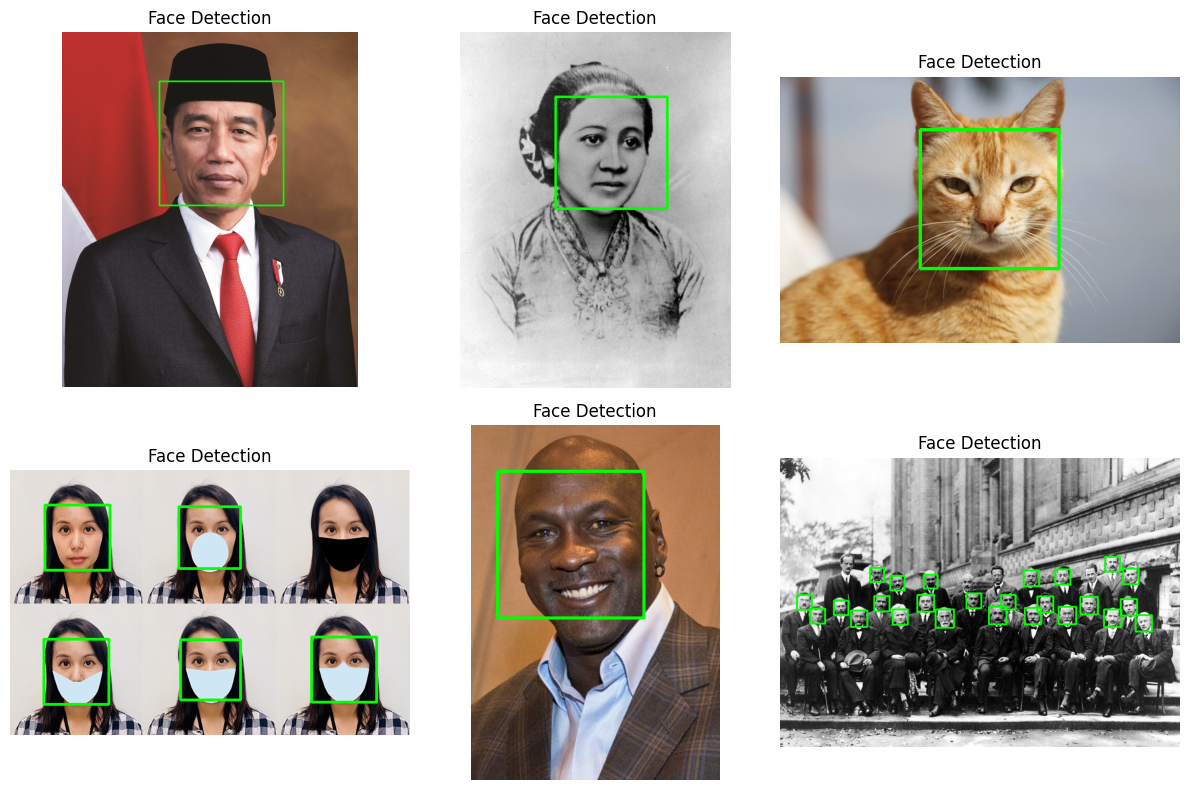

In [18]:
images = ['./jokowi.jpg', './kartini.jpg', './mycat.jpg', './mask.png', './mjordan.jpg', './solvayconf.jpg']

num_rows, num_cols = 2, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, image_path in enumerate(images):
    row, col = i // num_cols, i % num_cols
    img = load_image(image_path)

    if 'mycat.jpg' in image_path:
        result_image = cat_face_detection(img, scaleFactor=1.1, minNeighbors=5)
    else:
        result_image = face_detection(img, scaleFactor=1.2, minNeighbors=5)

    axes[row, col].imshow(result_image)
    axes[row, col].set_title('Face Detection')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

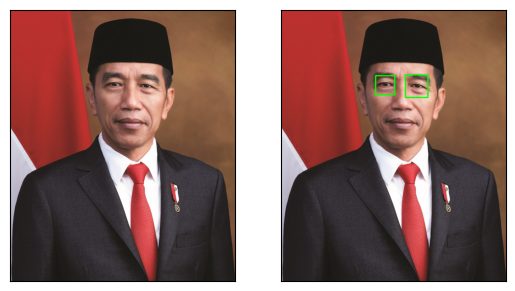

In [23]:
eyes_detection(cv2.imread('./jokowi.jpg'), 1.1, 9)

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


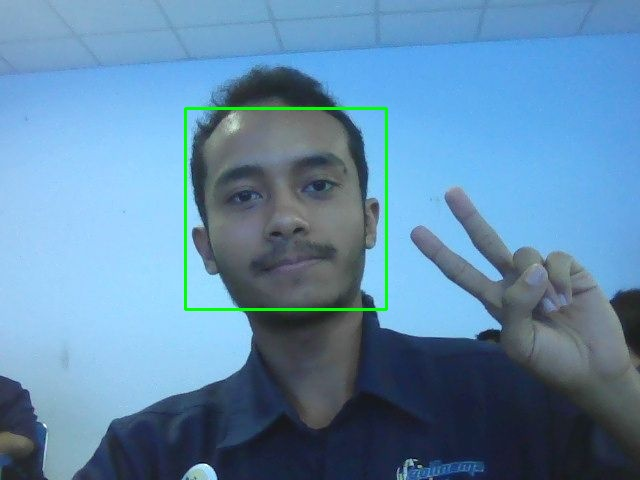

In [34]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)


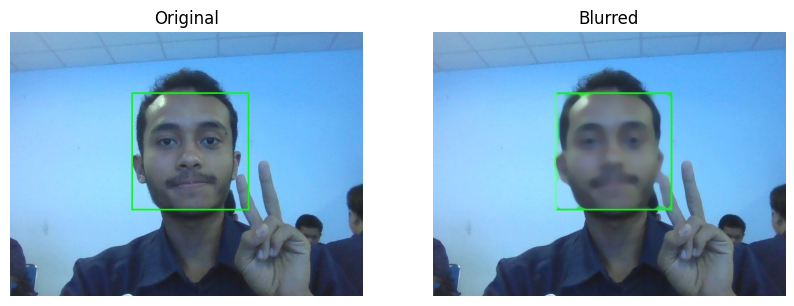

In [42]:
try:
    filename = take_photo('photo.jpg')
    img = load_image(filename)
    img_blurry = face_blurry(img)

    compare_images(img, img_blurry, title_before='Original', title_after='Blurred')
except Exception as err:
    print(str(err))

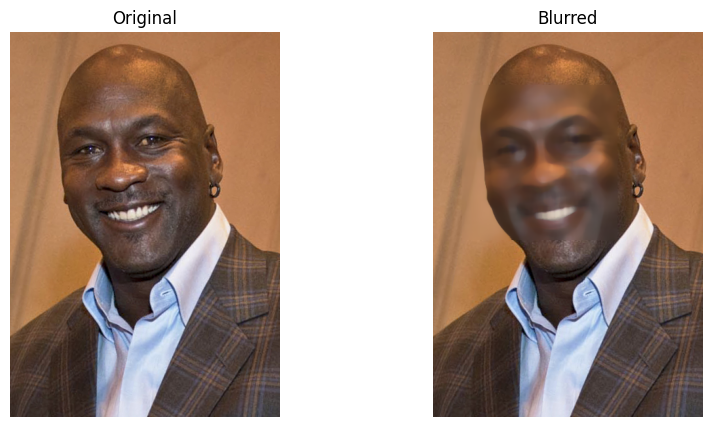

In [43]:
try:
    filename = 'mjordan.jpg'
    img = load_image(filename)
    img_blurry = face_blurry(img)

    compare_images(img, img_blurry, title_before='Original', title_after='Blurred')
except Exception as err:
    print(str(err))

## e-KTP

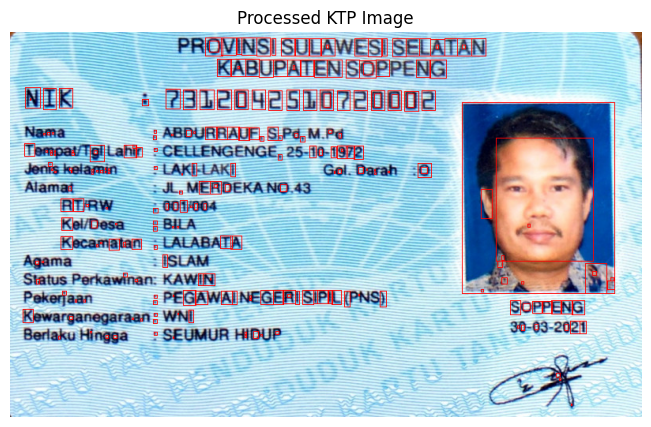

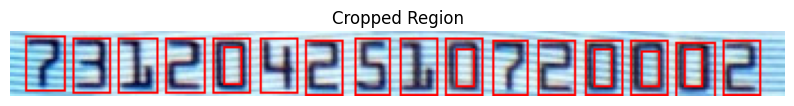

In [79]:
def process_ktp_image(image_path):
    ktp = cv2.imread(image_path)
    blurred = cv2.GaussianBlur(ktp, (5, 5), 0.5)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    ret, bw = cv2.threshold(gray.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    erode = cv2.erode(bw.copy(), cv2.getStructuringElement(cv2.MORPH_OPEN, (1, 1)))
    contours, hierarchy = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        ras = format(w / h, '.2f')
        if h >= 4 and w >= 1 and float(ras) <= 1:
            cv2.rectangle(ktp, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)
        elif h >= 2 and w >= 1 and float(ras) <= 1:
            cv2.rectangle(ktp, (x, y), (x + w, y + h), (0, 0, 255), thickness=1)

    return ktp

def show_image(image, title=''):
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

ktp_processed = process_ktp_image('KTP.jpg')
show_image(ktp_processed, 'Processed KTP Image')

cropped_img = ktp_processed[70:100, 190:550]
show_image(cropped_img, 'Cropped Region')

In [80]:
import os
import cv2
import numpy as np
import pickle
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam

(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
num_samples_per_class = 100

digits_to_extract = list(range(10))

def extract_samples(X, y, digits, num_samples):
    samples = []
    for digit in digits:
        digit_indices = np.where(y == digit)[0]
        selected_indices = np.random.choice(digit_indices, num_samples, replace=False)
        samples.extend([(X[i], digit) for i in selected_indices])
    return samples

training_data = extract_samples(X_train, y_train, digits_to_extract, num_samples_per_class)
np.random.shuffle(training_data)
X, Y = zip(*training_data)
X = np.array(X).reshape(-1, 28, 28, 1)

pickle_out = open("X_mnist.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("Y_mnist.pickle", "wb")
pickle.dump(to_categorical(Y, num_classes=10), pickle_out)
pickle_out.close()

11490434/11490434 [==============================] - 1s 0us/step


In [83]:
import pickle
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam

In [87]:
pickle_in = open("X_mnist.pickle", "rb")
X = pickle.load(pickle_in)
pickle_in = open("Y_mnist.pickle", "rb")
Y = pickle.load(pickle_in)

width, height = 28, 28  # Sesuaikan dengan ukuran gambar MNIST

inputs = Input(shape=(width, height, 1))
conv_layer = ZeroPadding2D(padding=(2, 2))(inputs)
conv_layer = Conv2D(16, (5, 5), strides=(1, 1), activation='relu')(conv_layer)
conv_layer = MaxPooling2D((2, 2))(conv_layer)
conv_layer = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(conv_layer)
conv_layer = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(conv_layer)
conv_layer = MaxPooling2D((2, 2))(conv_layer)
conv_layer = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv_layer)
flaten = Flatten()(conv_layer)
fc_layer = Dense(256, activation='relu')(flaten)
fc_layer = Dense(64, activation='relu')(fc_layer)
outputs = Dense(10, activation='softmax')(fc_layer)

adam = Adam(learning_rate=0.0001)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
model.fit(X, Y, epochs=20, verbose=1)
model.save('anpr.model')

Epoch 1/20
32/32 [==============================] - 5s 44ms/step - loss: 10.3277 - accuracy: 0.1470
Epoch 2/20
32/32 [==============================] - 2s 58ms/step - loss: 1.9387 - accuracy: 0.3950
Epoch 3/20
32/32 [==============================] - 1s 30ms/step - loss: 1.1643 - accuracy: 0.6250
Epoch 4/20
32/32 [==============================] - 1s 30ms/step - loss: 0.8828 - accuracy: 0.7320
Epoch 5/20
32/32 [==============================] - 1s 30ms/step - loss: 0.6795 - accuracy: 0.7790
Epoch 6/20
32/32 [==============================] - 1s 37ms/step - loss: 0.5495 - accuracy: 0.8250
Epoch 7/20
32/32 [==============================] - 2s 62ms/step - loss: 0.4435 - accuracy: 0.8540
Epoch 8/20
32/32 [==============================] - 2s 58ms/step - loss: 0.3488 - accuracy: 0.8950
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 0.2828 - accuracy: 0.9160
Epoch 10/20
32/32 [==============================] - 2s 57ms/step - loss: 0.2324 - accuracy: 0.9420
Epoch 11

32/32 [==============================] - 1s 10ms/step - loss: 2.2644 - accuracy: 0.9740
Accuracy on the test set: 97.40%


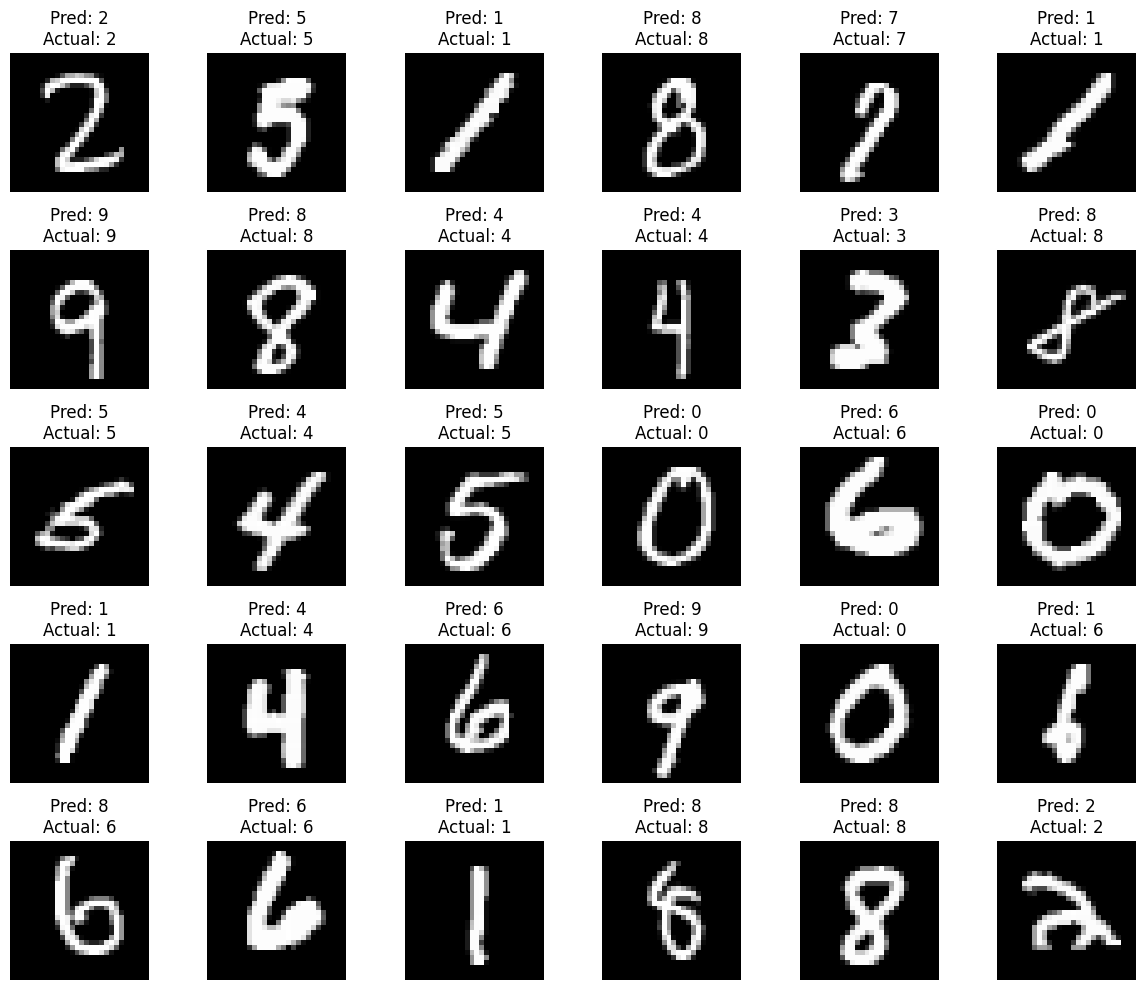

In [90]:
import os
import cv2
import numpy as np
import pickle
import tensorflow as tf
from keras.utils import to_categorical

# Load dataset MNIST yang sudah disiapkan sebelumnya
pickle_in = open("X_mnist.pickle", "rb")
X_test = pickle.load(pickle_in)
pickle_in = open("Y_mnist.pickle", "rb")
Y_test = pickle.load(pickle_in)

# Normalisasi data testing
X_test = X_test / 255.0

# Load model yang sudah di-training sebelumnya
model = tf.keras.models.load_model("anpr.model")

# Lakukan prediksi pada data testing
predictions = model.predict(X_test)

# Evaluasi performa model
accuracy = model.evaluate(X_test, Y_test)[1]
print("Accuracy on the test set: {:.2f}%".format(accuracy * 100))

import matplotlib.pyplot as plt

# Tampilkan 30 hasil uji dengan gambarnya
num_results_to_display = 30
fig, axes = plt.subplots(5, 6, figsize=(12, 10))

for i in range(num_results_to_display):
    predicted_label = np.argmax(predictions[i])
    actual_label = np.argmax(Y_test[i])

    # Ambil gambar dari data testing
    img = X_test[i].reshape((28, 28))  # Assuming the images are 100x100 pixels

    # Tampilkan gambar dan label
    axes[i // 6, i % 6].imshow(img, cmap='gray')
    axes[i // 6, i % 6].set_title(f'Pred: {predicted_label}\nActual: {actual_label}')
    axes[i // 6, i % 6].axis('off')

plt.tight_layout()
plt.show()

## Sedang proses karena masih error